<a href="https://colab.research.google.com/github/atick-faisal/Crowd-Emotion/blob/main/src/CE_Transfer_Learning_Xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
# data_dir = '/content/drive/MyDrive/Research/Crowd Emotion/Spectrograms/Mel/'

In [3]:
train_dir = '/content/drive/MyDrive/Research/Crowd Emotion v2/Spectrograms/Mel/Train'
test_dir = '/content/drive/MyDrive/Research/Crowd Emotion v2/Spectrograms/Mel/Test'

In [4]:
BATCH_SIZE = 32
IMG_SIZE = (299, 299)

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory                 = train_dir,
    validation_split          = 0.2,
    subset                    = "training",
    seed                      = 42,
    image_size                = IMG_SIZE,
    batch_size                = BATCH_SIZE
)

Found 4977 files belonging to 3 classes.
Using 3982 files for training.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory                 = train_dir,
    validation_split          = 0.2,
    subset                    = "validation",
    seed                      = 42,
    image_size                = IMG_SIZE,
    batch_size                = BATCH_SIZE
)

Found 4977 files belonging to 3 classes.
Using 995 files for validation.


In [7]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory                 = test_dir,
    image_size                = IMG_SIZE,
    batch_size                = BATCH_SIZE
)

Found 1171 files belonging to 3 classes.


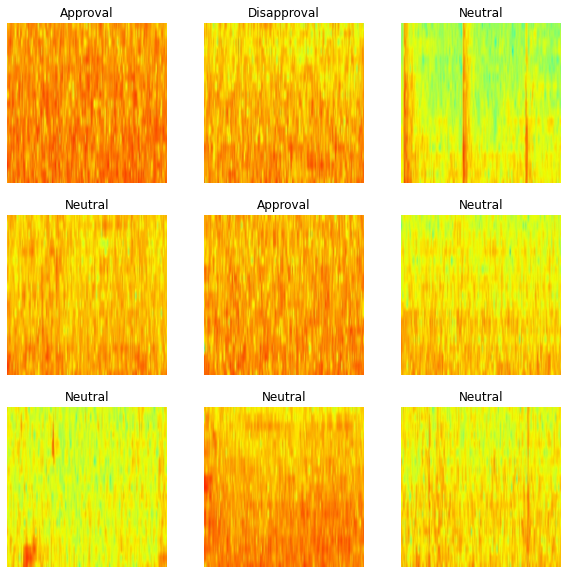

In [8]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [10]:
preprocess_input = tf.keras.applications.xception.preprocess_input

In [11]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [12]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.Xception(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [13]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 10, 10, 2048)


In [14]:
base_model.trainable = False

In [15]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [17]:
prediction_layer = tf.keras.layers.Dense(3)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


In [18]:
inputs = tf.keras.Input(shape=(299, 299, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [19]:
base_learning_rate = 0.0005
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 299, 299, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 299, 299, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 6147  

In [21]:
initial_epochs = 20

loss0, accuracy0 = model.evaluate(val_ds)

32/32 [==============================] - 546s 12s/step - loss: 1.1494 - accuracy: 0.3540


In [22]:
history = model.fit(train_ds,
                    epochs=10,
                    validation_data=val_ds)

Epoch 1/10
125/125 [==============================] - 2081s 17s/step - loss: 0.9383 - accuracy: 0.5844 - val_loss: 0.8407 - val_accuracy: 0.6412
Epoch 2/10
125/125 [==============================] - 45s 352ms/step - loss: 0.8175 - accuracy: 0.6552 - val_loss: 0.7997 - val_accuracy: 0.6422
Epoch 3/10
125/125 [==============================] - 43s 339ms/step - loss: 0.7880 - accuracy: 0.6675 - val_loss: 0.7777 - val_accuracy: 0.6543
Epoch 4/10
125/125 [==============================] - 44s 348ms/step - loss: 0.7710 - accuracy: 0.6733 - val_loss: 0.7623 - val_accuracy: 0.6683
Epoch 5/10
125/125 [==============================] - 44s 342ms/step - loss: 0.7558 - accuracy: 0.6828 - val_loss: 0.7512 - val_accuracy: 0.6653
Epoch 6/10
125/125 [==============================] - 44s 343ms/step - loss: 0.7453 - accuracy: 0.6823 - val_loss: 0.7429 - val_accuracy: 0.6704
Epoch 7/10
125/125 [==============================] - 44s 345ms/step - loss: 0.7322 - accuracy: 0.6911 - val_loss: 0.7288 - val_ac

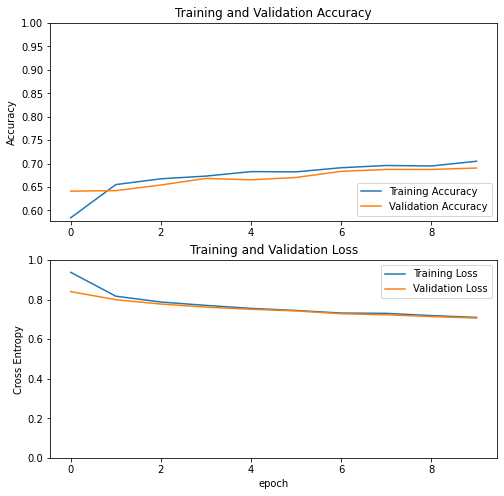

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [24]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

37/37 [==============================] - 678s 14s/step - loss: 0.8385 - accuracy: 0.6550
Loss:  0.8384584188461304
Accuracy:  0.6549957394599915


In [25]:
""" v1
        CHANNEL         TRAINING          VALIDATION
        BARK              90.18              88.85
        ERB               67.04              70.69
        LOG               90.38              88.59
        MEL               71.13              69.78
"""

' v1\n        CHANNEL         TRAINING          VALIDATION\n        BARK              90.18              88.85\n        ERB               67.04              70.69\n        LOG               90.38              88.59\n        MEL               71.13              69.78\n'

In [26]:
""" v2
        CHANNEL         TRAINING          VALIDATION        TESTING
        BARK              84.30              86.33           82.23              
        ERB               72.07              68.64           62.85
        LOG               85.69              85.53           78.73
        MEL               70.49              69.45           65.50
"""

' v2\n        CHANNEL         TRAINING          VALIDATION        TESTING\n        BARK              84.30              86.33           82.23              \n        ERB               72.07              68.64           62.85\n        LOG               85.69              85.53           78.73\n        MEL               71.13              69.78\n'